<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [ ]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

In [ ]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np


## Задание 1 (2 балла). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекоммендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



В качестве временного ряда с **месячной частотой** будет использоваться датасет об импорте нефти в США из [предложенного источника](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc). Объем данных - 145 наблюдений за 12 лет

В качестве временного ряда с **дневной частотой** будет использоваться набор данных о количестве арендованных велосипедов в Лондоне. Датасет размещен на платформе [kaggle](https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries?select=power_usage_2016_to_2020.csv). Изначальная частота наблюдений в датасете - часы, он будет переведен в дневную частоту суммированием арендованных велосипедов за сутки, так как каждое наблюдение в изначальном датасете - количество новых аренд за определенный час. В данных был один день с пропущенным значением, он был заполнен значением прошлого дня для избежания проблем со сдвигом сезонностей.

Оба датасета были скачаны и сохранены на гугл-диске на случай изменения данных в оригинальных источниках

In [ ]:
# скачаем данные
!wget 'https://drive.google.com/uc?export=download&id=1jJs4GqyhqyimrwazD5KhUrV13xaKZgot'
!wget 'https://drive.google.com/uc?export=download&id=1ZdNZE6IjWpm3PWWYzvW9WcIwuYMRfsDJ'

In [ ]:
# считаем файлы
ts1 = pd.read_csv('/content/uc?export=download&id=1jJs4GqyhqyimrwazD5KhUrV13xaKZgot')
ts2 = pd.read_csv('/content/uc?export=download&id=1ZdNZE6IjWpm3PWWYzvW9WcIwuYMRfsDJ')

In [ ]:
ts1['Date'] = pd.to_datetime(ts1['Date'].str.strip(), format='%Y %m')
ts1.columns = ['Date', 'Import']

In [ ]:
# код для обработки второго временного ряда
# ts2['timestamp'] = pd.to_datetime(ts2['timestamp'])
# ts2 = ts2.groupby(ts2['timestamp'].dt.date)['cnt'].sum().reset_index()
# ts2 = pd.DataFrame(pd.DatetimeIndex(pd.date_range(start='2015-01-04', end='2017-01-03', freq='1d'))).join(ts2.set_index('timestamp'),on=0).fillna(method='ffill')
# ts2 = ts2[['timestamp', 'cnt']]
# ts2.columns = ['Date', 'cnt']

In [ ]:
ts2['Date'] = pd.to_datetime(ts2['Date'])
ts2.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
ts1_train = ts1[:int(len(ts1)*0.8)]
ts1_test = ts1[int(len(ts1)*0.8):]
ts2_train = ts2[:int(len(ts2)*0.8)]
ts2_test = ts2[int(len(ts2)*0.8):]

## Задание 2. Анализ временных рядов (1 балла).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики автокорреляционных функций для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

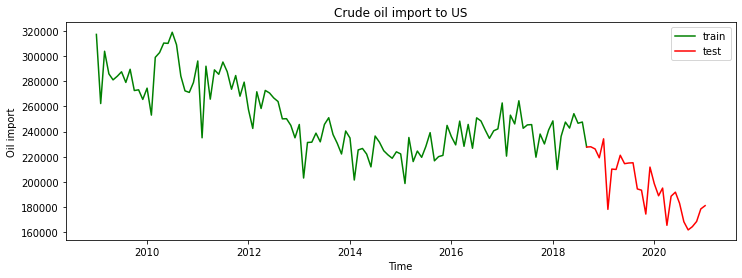

In [ ]:
# отрисуем временные ряды
plt.figure(figsize=(12, 4))
plt.plot(ts1[:len(ts1_train)+1]['Date'], ts1[:len(ts1_train)+1]['Import'], color='green', label='train')
plt.plot(ts1_test['Date'], ts1_test['Import'], color='red', label='test')
plt.xlabel('Time')
plt.ylabel('Oil import')
plt.title('Crude oil import to US')
plt.legend()
plt.show()

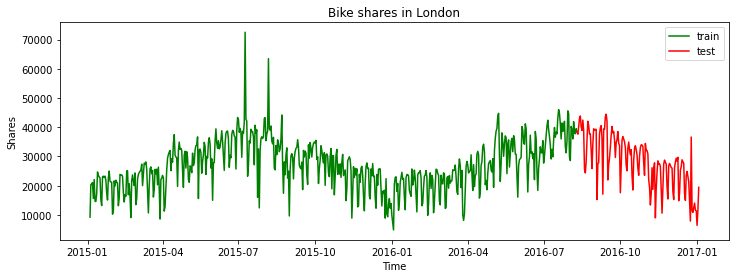

In [ ]:
# отрисуем временные ряды
plt.figure(figsize=(12, 4))
plt.plot(ts2[:len(ts2_train)+1]['Date'], ts2[:len(ts2_train)+1]['cnt'], color='green', label='train')
plt.plot(ts2_test['Date'], ts2_test['cnt'], color='red', label='test')
plt.xlabel('Time')
plt.ylabel('Shares')
plt.title('Bike shares in London')
plt.legend()
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

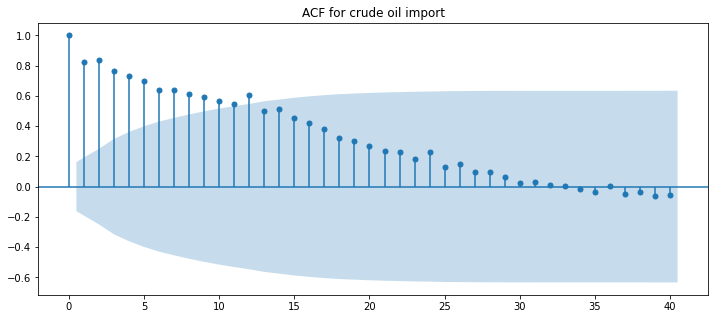

In [ ]:
fig = plot_acf(ts1['Import'], lags=40)
fig.set_size_inches(12, 5)
plt.title('ACF for crude oil import')
plt.show()

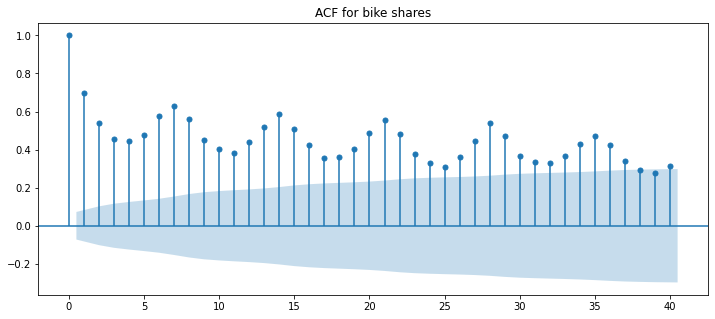

In [ ]:
fig = plot_acf(ts2['cnt'], lags=40)
fig.set_size_inches(12, 5)
plt.title('ACF for bike shares')
plt.show()

В ряде импорт нефти в США присутствует некоторая сезонность порядка 12 месяцев, особенно ярко она проявляется в начале года

In [ ]:
ts1_gr = ts1.groupby([ts1['Date'].dt.year, ts1['Date'].dt.month]).last()

In [ ]:
ts1_gr.index = ts1_gr.index.set_names(['YEAR', 'MONTH'])
ts1_gr = ts1_gr.sort_values(by='Date')

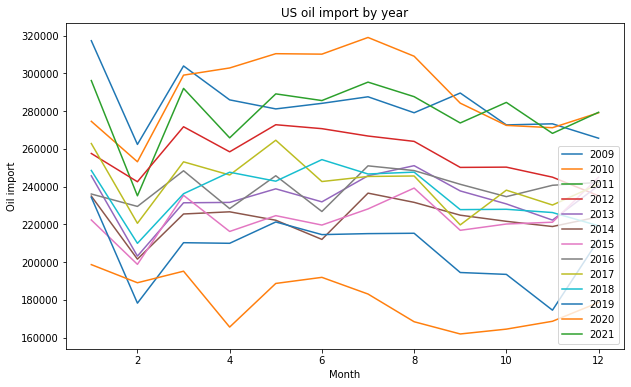

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(2009, 2022):
    plt.plot(ts1_gr.loc[i]['Date'].dt.month,
        ts1_gr.loc[i]['Import'], label=i)
plt.legend()
plt.xlabel('Month')
plt.ylabel('Oil import')
plt.title('US oil import by year')
plt.show()

Во временном ряде продаж ресторана также присутствует сильная годовая сезонность. Месячная сезонность не наблюдается. Для определения недельной сезонности были построены графики для некоторых случайных недель 2016 года. Сезонность наблюдается, но не для всех из них.

In [ ]:
ts2_gr = ts2.groupby([ts2['Date'].dt.year, ts2['Date'].dt.month, ts2['Date'].dt.isocalendar().week, ts2['Date'].dt.day]).last()
ts2_gr.index = ts2_gr.index.set_names(['YEAR', 'MONTH', 'WEEK', 'DAY'])
ts2_gr = ts2_gr.sort_values(by='Date')

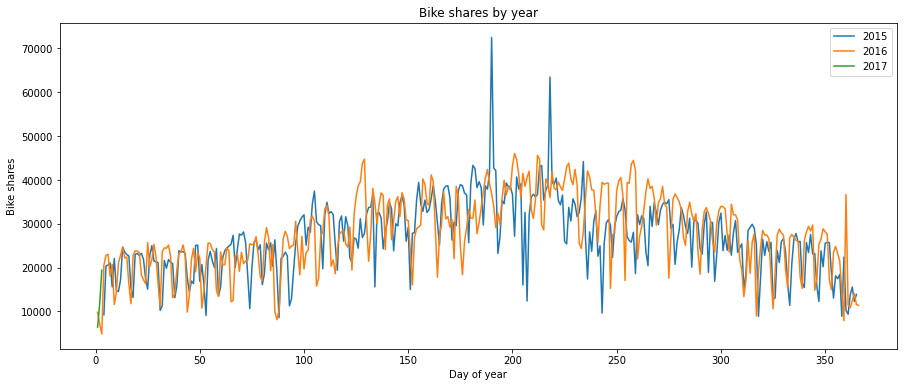

In [ ]:
plt.figure(figsize=(15, 6))
for i in range(2015, 2018):
    plt.plot(ts2_gr.loc[i]['Date'].dt.dayofyear.values,
             ts2_gr.loc[i]['cnt'], label=i)
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Bike shares')
plt.title('Bike shares by year')
plt.show()

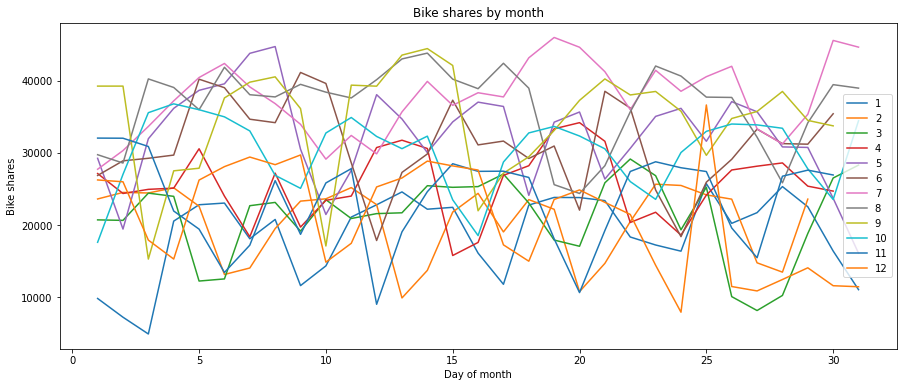

In [ ]:
plt.figure(figsize=(15, 6))
for week in range(1,13):
    plt.plot(ts2_gr[(ts2_gr.index.get_level_values('MONTH')==week)&(ts2_gr.index.get_level_values('YEAR')==2016)]['Date'].dt.day.values,
             ts2_gr[(ts2_gr.index.get_level_values('MONTH')==week)&(ts2_gr.index.get_level_values('YEAR')==2016)]['cnt'], label=week)
plt.legend()
plt.xlabel('Day of month')
plt.ylabel('Bike shares')
plt.title('Bike shares by month')
plt.show()

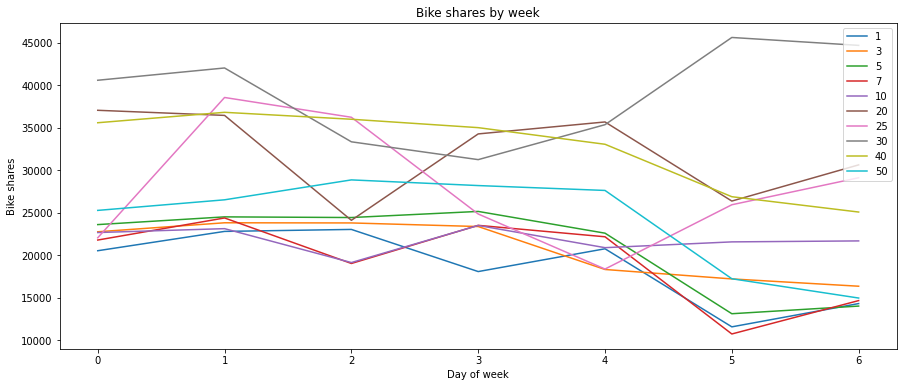

In [ ]:
plt.figure(figsize=(15, 6))
for week in [1, 3, 5, 7, 10, 20, 25, 30, 40, 50]:
    plt.plot(ts2_gr[(ts2_gr.index.get_level_values('WEEK')==week)&(ts2_gr.index.get_level_values('YEAR')==2016)]['Date'].dt.dayofweek.values,
             ts2_gr[(ts2_gr.index.get_level_values('WEEK')==week)&(ts2_gr.index.get_level_values('YEAR')==2016)]['cnt'], label=week)
plt.legend()
plt.xlabel('Day of week')
plt.ylabel('Bike shares')
plt.title('Bike shares by week')
plt.show()

## Задание 3. Предсказание месячного временного ряда (4.5 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.


### NaiveForecaster из sktime (0.5 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

naive = NaiveForecaster(strategy='last')
season = NaiveForecaster(strategy='last', sp=12)

naive.fit(ts1_train['Import'])
season.fit(ts1_train['Import'])

NaiveForecaster(sp=12)

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
print('Naive no season MAE:'+ str(mae(ts1_test["Import"],
                                 naive.predict(np.arange(len(ts1_test)))))) 

print('Naive with season MAE:'+ str(mae(ts1_test["Import"],
                                 season.predict(np.arange(len(ts1_test))))))

Naive no season MAE:50723.862068965514
Naive with season MAE:41662.48275862069


### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

arima = ARIMA(order=(1,1,1), seasonal_order=(1,0,0,12))
autoarima = AutoARIMA(start_q=1)
arima.fit(ts1_train['Import'])
autoarima.fit(ts1_train['Import'])

AutoARIMA(start_q=1)

In [ ]:
print('ARIMA MAE:'+ str(mae(ts1_test["Import"],
                                 arima.predict(np.arange(len(ts1_test)))))) 

print('AUTOARIMA MAE:'+ str(mae(ts1_test["Import"],
                                 autoarima.predict(np.arange(len(ts1_test))))))

ARIMA MAE:42274.13561799593
AUTOARIMA MAE:50584.91108619029


/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [ ]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull

lgt = LGTFull(response_col='Import',
              date_col='Date',
              seasonality=12,
              seed=6)
dlt = DLTFull(response_col='Import',
              date_col='Date',
              seasonality=12,
              seed=6)

lgt.fit(ts1_train)
dlt.fit(ts1_train)

In [ ]:
print('LGT MAE:'+ str(mae(ts1_test["Import"],
                                 lgt.predict(ts1_test)['prediction']))) 

print('DLT MAE:'+ str(mae(ts1_test["Import"],
                                dlt.predict(ts1_test)['prediction'])))

LGT MAE:37877.13565265089
DLT MAE:46098.02505523192


### ETS (2 балла).

Обучите из библиотеки `sklearn` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

exp = ExponentialSmoothing(trend='add', seasonal='add', sp=12)
auto_ets = AutoETS(auto=True, information_criterion='aic', 
                   allow_multiplicative_trend=True, n_jobs=-1)

exp.fit(ts1_train['Import'])
auto_ets.fit(ts1_train['Import'].astype(float))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


AutoETS(allow_multiplicative_trend=True, auto=True, n_jobs=-1)

In [ ]:
print('ETS(AAA):'+ str(mae(ts1_test["Import"],
                                 exp.predict(np.arange(len(ts1_test)))))) 

print('ETS Auto:'+ str(mae(ts1_test["Import"],
                                 auto_ets.predict(np.arange(len(ts1_test))))))

ETS(AAA):38738.42322329085
ETS Auto:48794.73966328273


Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

Лучшая модель - LGT

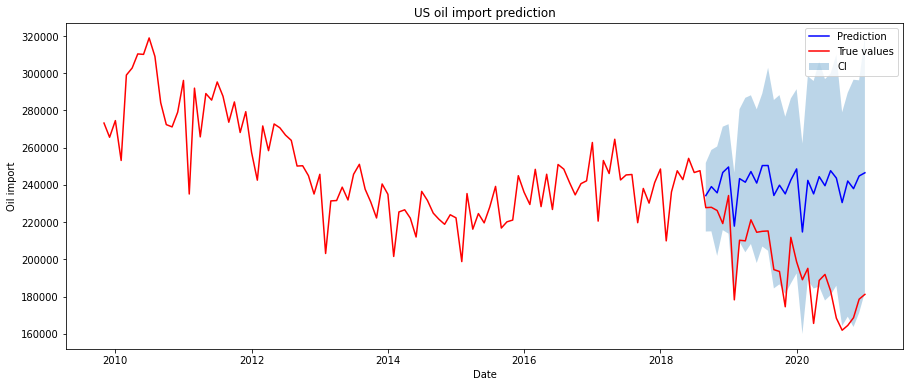

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(ts1_test['Date'], lgt.predict(ts1_test)['prediction'], label='Prediction', color='blue')
plt.plot(ts1['Date'][10:], ts1['Import'][10:], label='True values', color='red')
plt.fill_between(ts1_test['Date'], lgt.predict(ts1_test)['prediction_5'], lgt.predict(ts1_test)['prediction_95'], alpha=0.3, label='CI')
plt.xlabel('Date')
plt.ylabel('Oil import')
plt.legend()
plt.title('US oil import prediction')
plt.show()

## Задание 4. Предсказание дневного временного ряда (2.5 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (0.5 балла).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

naive = NaiveForecaster(strategy='last')
season = NaiveForecaster(strategy='last', sp=365)

naive.fit(ts2_train['cnt'])
season.fit(ts2_train['cnt'])

NaiveForecaster(sp=365)

In [ ]:
print('Naive no season MAE:'+ str(mae(ts2_test["cnt"],
                                 naive.predict(np.arange(len(ts2_test)))))) 

print('Naive with season MAE:'+ str(mae(ts2_test["cnt"],
                                        season.predict(np.arange(len(ts2_test))))))

Naive no season MAE:11523.020408163266
Naive with season MAE:7488.646258503401


### KTR из orbit (1 балл).



In [ ]:
from orbit.models.ktrlite import KTRLiteMAP

ktr = KTRLiteMAP(
    response_col='cnt',
    date_col='Date',
    seasonality = [7, 30, 365]
)

ktr.fit(ts2_train)

In [ ]:
print('KTR MAE:' + str(mae(ts2_test['cnt'],
                           ktr.predict(ts2_test)['prediction'])))

KTR MAE:7439.0477141538


### Phophet (1 балл).



In [ ]:
ts2_train_prophet = ts2_train.copy()
ts2_train_prophet.columns = ['ds', 'y']

In [ ]:
from prophet import Prophet

prophet = Prophet(yearly_seasonality=True)
prophet.fit(ts2_train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = prophet.make_future_dataframe(periods=len(ts2_test), include_history=False)
print('Prophet MAE:' + str(mae(ts2_test['cnt'],
                               prophet.predict(future)['yhat'])))

Prophet MAE:5079.30797944342


Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

Лучшая модель - Prophet

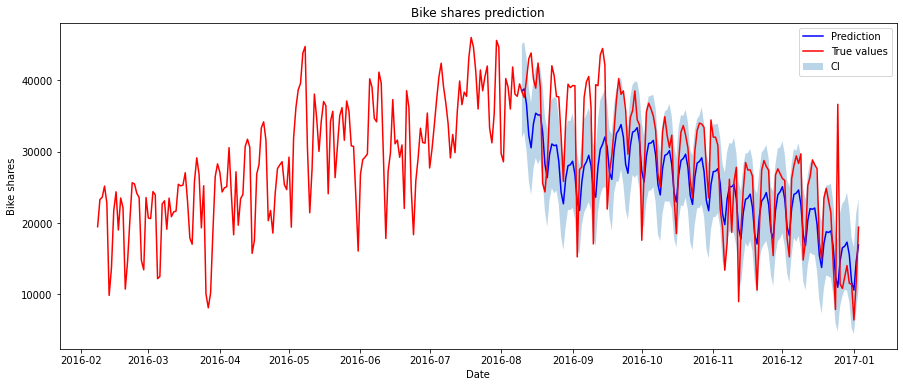

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(ts2_test['Date'], prophet.predict(future)['yhat'], label='Prediction', color='blue')
plt.plot(ts2['Date'][400:], ts2['cnt'][400:], label='True values', color='red')
plt.fill_between(ts2_test['Date'], prophet.predict(future)['yhat_lower'], prophet.predict(future)['yhat_upper'], alpha=0.3, label='CI')
plt.xlabel('Date')
plt.ylabel('Bike shares')
plt.legend()
plt.title('Bike shares prediction')
plt.show()